In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

import statsmodels.api as sm
from scipy import stats

import torch
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.data.sampler import RandomSampler
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

print(torch.__version__)
print(f'Is MPS (Metal Performance Shader) even available? {torch.backends.mps.is_available()}')
print(f'Was the current version of PyTorch built with MPS activated? {torch.backends.mps.is_built()}')

mps_device = torch.device("mps")

import random
SEED = 42
random.seed = SEED
np.random.seed(SEED)

2.2.0.dev20231010
Is MPS (Metal Performance Shader) even available? True
Was the current version of PyTorch built with MPS activated? True


In [2]:
# Load data

raw_train = pd.read_csv("data/m5/sales_train_evaluation.csv")
raw_test = pd.read_csv("data/m5/sales_test_evaluation.csv")
calendar = pd.to_datetime(pd.read_csv("data/m5/calendar.csv").date)

In [3]:
# Id's

item_id_dict = dict(zip(raw_train.item_id.unique(), np.arange(raw_train.item_id.unique().shape[0])))
dept_id_dict = dict(zip(raw_train.dept_id.unique(), np.arange(raw_train.dept_id.unique().shape[0])))
cat_id_dict = dict(zip(raw_train.cat_id.unique(), np.arange(raw_train.cat_id.unique().shape[0])))
store_id_dict = dict(zip(raw_train.store_id.unique(), np.arange(raw_train.store_id.unique().shape[0])))
state_id_dict = dict(zip(raw_train.state_id.unique(), np.arange(raw_train.state_id.unique().shape[0])))

ts_id = np.arange(0, raw_train.shape[0])
ts_item_id = np.array([item_id_dict[v] for v in raw_train.item_id])
ts_dept_id = np.array([dept_id_dict[v] for v in raw_train.dept_id])
ts_cat_id = np.array([cat_id_dict[v] for v in raw_train.cat_id])
ts_store_id = np.array([store_id_dict[v] for v in raw_train.store_id])
ts_state_id = np.array([state_id_dict[v] for v in raw_train.state_id])

In [4]:
train_ts = raw_train[raw_train.columns[5:]].values
test_ts = raw_test[raw_test.columns[5:]].values

train_idx = calendar[:train_ts.shape[1]]
test_idx = calendar[-test_ts.shape[1]:]

T = train_ts.shape[1]
DECODER_LEN = test_ts.shape[1]      # DECODER_LEN = 28
ENCODER_LEN = DECODER_LEN * 2       # ENCODER_LEN = 140

# Filter

filter = np.logical_and(ts_store_id == 0, ts_dept_id == 4)   # Store 0:CA_1, Department:FOODS_3

train_ts = train_ts[filter,]
test_ts = test_ts[filter,]

train_ts.shape, train_idx.shape, test_ts.shape, test_idx.shape

((216, 1941), (1941,), (216, 28), (28,))

In [5]:
# find first nonzero value in each time series

nonzero_t = np.argmax(train_ts != 0, axis=1)
nonzero_t.shape

(216,)

In [6]:
# Covariate

num_covariates = 4      # age, day, weekday, month

covariates_t = np.zeros((calendar.shape[0], num_covariates))
for i, t in enumerate(calendar):
    covariates_t[i, 1] = t.day
    covariates_t[i, 2] = t.weekday()
    covariates_t[i, 3] = t.month
for i in range(1,num_covariates):
    covariates_t[:,i] = stats.zscore(covariates_t[:,i])

covariates_age = [stats.zscore( np.arange(T + DECODER_LEN - start) ) for start in nonzero_t]

covariates_t.shape, len(covariates_age)

((1969, 4), 216)

In [7]:
# z         target values
# x         covariates for each timestep (conditional range + prediction range)
# z_start   start index of each time series
# z_ids     id of each time series
def lag(z, x, x_age, z_start, window_size, h, stride=1):
    X = []
    Y = []
    v = []
    for i in tqdm(range(train_ts.shape[0])):
        start = z_start[i]
        x[start:T, 0] = x_age[i][:T-start]

        count=0
        window_start = stride * count + start
        window_end = window_start + window_size
        while True:
            # input for time series i and window t: {z_it, x_it}
            in_it = np.zeros((window_size, 1+x.shape[1]+1), dtype=np.float32)
            in_it[1:,0] = z[i, window_start:window_end-1]
            in_it[:,1:1+x.shape[1]] = x[window_start:window_end,:]
            in_it[:, -1] = i
            # labels
            out_it = np.zeros(window_size, dtype=np.float32)
            out_it[:] = z[i, window_start:window_end]
            # scaling
            v_it = 0
            nonzero_sum = (in_it[1:(window_size-h), 0]!=0).sum()
            if nonzero_sum != 0:
                v_it = np.true_divide(in_it[1:(window_size-h), 0].sum(),nonzero_sum)+1
                in_it[:, 0] = in_it[:, 0] / v_it
                out_it = out_it / v_it

            X.append(in_it)
            Y.append(out_it)
            v.append(v_it)
            count+=1
            window_start = stride * count + start
            window_end = window_start + window_size
            if (window_end >= T):
                break

    X = np.stack(X)
    Y = np.stack(Y)
    v = np.array(v)

    return X, Y, v

X, Y, v = lag(train_ts, covariates_t.copy(), covariates_age, nonzero_t, window_size=ENCODER_LEN+DECODER_LEN, h=DECODER_LEN, stride=DECODER_LEN)
X.shape, Y.shape, v.shape

100%|██████████| 216/216 [00:00<00:00, 2362.00it/s]


((12235, 84, 6), (12235, 84), (12235,))

In [8]:
# |----------------- (a) -----------------|----- (b) -----|----- (c) -----|
#   (a) conditional range
#   (b) validation range
#   (c) prediction range

samples_id = X[:,0,-1]
idx = 0
val_idx = []
for id in tqdm(np.unique(samples_id)):
    mask = samples_id == id
    nsamples = np.sum(mask)
    val_idx.append( (np.arange(nsamples) + idx)[-int(nsamples*0.25):] )
    idx += nsamples
all_idx = np.arange(X.shape[0])
val_idx = np.hstack(val_idx)
train_idx = np.setdiff1d(all_idx, val_idx)

Xtrain = X[train_idx,:,:];  Ytrain = Y[train_idx,:];    vtrain = v[train_idx]
Xval = X[val_idx,:,:];      Yval = Y[val_idx,:];        vval = v[val_idx]

Xtrain.shape, Ytrain.shape, vtrain.shape, Xval.shape, Yval.shape, vval.shape

100%|██████████| 216/216 [00:00<00:00, 30581.25it/s]


((9292, 84, 6), (9292, 84), (9292,), (2943, 84, 6), (2943, 84), (2943,))

In [9]:
# Test set

Xtest = []
Ytest = []
vtest = []
for i in tqdm(range(test_ts.shape[0])):
    in_i = np.zeros((ENCODER_LEN+DECODER_LEN, 1+num_covariates+1), dtype=np.float32)
    in_i[1:ENCODER_LEN+1, 0] = train_ts[i,-ENCODER_LEN:]
    in_i[-(DECODER_LEN-1):, 0] = np.nan
    in_i[:,1] = covariates_age[i][-(ENCODER_LEN+DECODER_LEN):]
    in_i[:,2:2+num_covariates] = covariates_t[-(ENCODER_LEN+DECODER_LEN):,:]
    in_i[:, -1] = i

    out_i = np.zeros(ENCODER_LEN+DECODER_LEN, dtype=np.float32)
    out_i[0:ENCODER_LEN] = train_ts[i,-ENCODER_LEN:]
    out_i[-DECODER_LEN:] = test_ts[i,:DECODER_LEN]

    v_i = 0
    nonzero_sum = (in_i[1:ENCODER_LEN, 0]!=0).sum()
    if nonzero_sum != 0:
        v_i = np.true_divide(in_i[1:ENCODER_LEN, 0].sum(),nonzero_sum)+1
        in_i[:, 0] = in_i[:, 0] / v_i

    Xtest.append(in_i)
    Ytest.append(out_i)
    vtest.append(v_i)

Xtest = np.stack(Xtest)
Ytest = np.stack(Ytest)
vtest = np.array(vtest)

Xtest.shape, Ytest.shape, vtest.shape

100%|██████████| 216/216 [00:00<00:00, 42259.99it/s]


((216, 84, 6), (216, 84), (216,))

In [ ]:
# S = 1
# plt.plot((Xtest[S,:,0]*vtest[S]), label="z_t-1") 
# plt.plot(Ytest[S,:], label="z_t")
# plt.legend()
# plt.show

# for t in range(ENCODER_LEN+DECODER_LEN):
#     print(f'{t} \t z_t-1: {(Xtest[S,t,0]*vtest[S]):.2f} \t\t x_t: {Xtest[S,t,3]:.3f} \t\t z_t:{(Ytest[S,t]):.2f}')
#     if t == ENCODER_LEN-1:
#         print('---------------------------------------------------------------')

# train_ts[S][-ENCODER_LEN:], test_ts[S]

# PyTorch Dataset

In [10]:
# PyTorch data structure

class Data(Dataset):
    def __init__(self, X, Y, v):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.Y = torch.from_numpy(Y.astype(np.float32))
        self.v = torch.from_numpy(v.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return (self.X[index,:,:-1], 
                self.Y[index], 
                self.X[index,0,-1].to(torch.int32), 
                self.v[index])
            
    def __len__(self):
        return self.len
    
class WeightedSampler(Sampler):
    def __init__(self, v, replacement=True):
        self.weights = torch.from_numpy( (np.abs(v) / np.sum(np.abs(v))).astype(np.float32) )
        self.num_samples = self.weights.shape[0]
        self.replacement = replacement

    def __iter__(self):
        return iter(torch.multinomial(self.weights, self.num_samples, self.replacement).tolist())

    def __len__(self):
        return self.num_samples

In [11]:
train_data = Data(Xtrain, Ytrain, vtrain)
train_sampler = WeightedSampler(vtrain)
train_dataloader = DataLoader(dataset=train_data, batch_size=128, sampler=train_sampler)

val_data = Data(Xval, Yval, vval)
val_dataloader = DataLoader(dataset=val_data, batch_size=128, sampler=RandomSampler(val_data))

# Check it's working
for batch, (in_, out_, id_, v_) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {in_.shape}, device: {in_.device}")
    print(f"Y shape: {out_.shape}, device: {out_.device}")
    print(f"id shape: {id_.shape}, device: {id_.device}")
    print(f"v shape: {v_.shape}, device: {v_.device}")
    break

Batch: 1
X shape: torch.Size([128, 84, 5]), device: cpu
Y shape: torch.Size([128, 84]), device: cpu
id shape: torch.Size([128]), device: cpu
v shape: torch.Size([128]), device: cpu


In [12]:
# Docs > torch.nn > Embedding (https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
# num_embeddings:   size of the dictionary of embeddings
# embedding_dim:    the size of each embedding vector

# Docs > torch.nn > LSTM (https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
# n.b. the following with batch_first=True
# X     (N, L, Hin);
# h_0   (D * num_layers, Hout), Default to zeros if (h_0, c_0) is not provided;
# c_0   (D * num_layers, N, Hcell), Default to zeros if (h_0, c_0) is not provided.

# N = batch size
# L = sequence length
# D = 2 if bidirectional=True otherwise 1
# Hin = input_size
# Hcell = hidden_size
# Hout = proj_size if proj_size > 0 otherwise hidden_size

class DeepARNet(nn.Module):
    def __init__(self, nts, num_covariates, embedding_dim, hidden_dim, num_layers, device):
        super(DeepARNet, self).__init__()

        self.nts = nts
        self.num_covariates = num_covariates
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device

        self.embedding = nn.Embedding(nts, embedding_dim)
        self.lstm = nn.LSTM(input_size=1+num_covariates+embedding_dim,     # the size of the input at each time step       
                            hidden_size=hidden_dim,          # the size of the hidden state and cell state at each time step
                            num_layers=num_layers,           # the number of LSTM layers stacked on top of each other
                            batch_first=True,
                            dropout=0.1)
        self.distribution_mu = nn.Linear(hidden_dim * num_layers, 1)
        self.distribution_sigma_ = nn.Linear(hidden_dim * num_layers, 1)
        self.distribution_sigma = nn.Softplus()

        # initialize forget bias to 1.0 (http://proceedings.mlr.press/v37/jozefowicz15.pdf)
        # to reduce the scale of forgetting in the beginning of the training
        # bias_ih_l[k] – the learnable input-hidden bias of the k-th layer
        # - (b_ii|b_if|b_ig|b_io), of shape (4*hidden_size)
        # bias_hh_l[k] – the learnable hidden-hidden bias of the k-th layer
        # - (b_hi|b_hf|b_hg|b_ho), of shape (4*hidden_size)
        for layer_weigths in self.lstm._all_weights:
            bias_names = [w for w in layer_weigths if 'bias' in w]
            for name in bias_names:
                bias = getattr(self.lstm, name)
                bias.data[(self.hidden_dim // 4):(self.hidden_dim // 2)].fill_(1.)
       
    def forward(self, input, ids, hidden, cell):
        ids_embed = self.embedding(ids)
        lstm_input = torch.concat((input, ids_embed), dim=1)
        _, (hidden, cell) = self.lstm(lstm_input.unsqueeze(1), (hidden, cell))
        hidden_ = hidden.permute(1,2,0).contiguous().view(hidden.shape[1], -1)
        mu = self.distribution_mu(hidden_)
        sigma_ = self.distribution_sigma_(hidden_)
        sigma = self.distribution_sigma(sigma_)
        return torch.squeeze(mu), torch.squeeze(sigma), hidden, cell
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=self.device)

    def init_cell(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=self.device)

In [13]:
# Instantiate model, loss and optimizer

model = DeepARNet(nts=train_ts.shape[0], 
                  num_covariates=4,
                  embedding_dim=24, 
                  hidden_dim = 56, 
                  num_layers = 3, 
                  device=mps_device)
print(model)

if torch.backends.mps.is_available():
    model.to(mps_device)

learning_rate = 1e-4

def GaussianLogLikehoodLoss(mu: Variable, sigma: Variable, y: Variable):
    distribution = torch.distributions.Normal(loc=mu, scale=sigma)
    likelihood = distribution.log_prob(y)
    return -torch.mean(likelihood)

loss_fn = GaussianLogLikehoodLoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DeepARNet(
  (embedding): Embedding(216, 24)
  (lstm): LSTM(29, 56, num_layers=3, batch_first=True, dropout=0.1)
  (distribution_mu): Linear(in_features=168, out_features=1, bias=True)
  (distribution_sigma_): Linear(in_features=168, out_features=1, bias=True)
  (distribution_sigma): Softplus(beta=1, threshold=20)
)


In [14]:
# Training loop

num_epochs = 100

best_val_loss = np.inf
best_model = None
PATIENCE = 20
min_delta = 0.001
current_patience = 0

history = {
     'train_loss': [],
     'val_loss': []
}

for epoch in range(num_epochs):

    train_loss = 0.0
    model.train()
    for in_, out_, id_, v_ in train_dataloader:
        optimizer.zero_grad()
        in_ = in_.to(mps_device)
        out_ = out_.to(mps_device)
        id_ = id_.to(mps_device)
        loss = torch.zeros(1, device=mps_device)
        hidden = model.init_hidden(batch_size=in_.shape[0])
        cell = model.init_cell(batch_size=in_.shape[0])
        for t in range(ENCODER_LEN+DECODER_LEN):
            mu, sigma, hidden, cell = model(in_[:,t,:], id_, hidden, cell)
            #if (t>=ENCODER_LEN):
            loss += loss_fn(mu, sigma, out_[:,t])
        loss.backward()        
        optimizer.step()
        train_loss += loss.item() / (ENCODER_LEN+ DECODER_LEN)   # loss per timestep
    history['train_loss'].append(train_loss / len(train_dataloader))

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for in_, out_, id_, v_ in val_dataloader:
            in_ = in_.to(mps_device)
            out_ = out_.to(mps_device)
            id_ = id_.to(mps_device)
            loss = 0
            hidden = model.init_hidden(batch_size=in_.shape[0])
            cell = model.init_cell(batch_size=in_.shape[0])
            for t in range(ENCODER_LEN+DECODER_LEN):
                mu, sigma, hidden, cell = model(in_[:,t,:], id_, hidden, cell)
                #if (t>=ENCODER_LEN):
                loss += loss_fn(mu, sigma, out_[:,t]).item()
            val_loss += loss / (ENCODER_LEN+DECODER_LEN)
    history['val_loss'].append(val_loss / len(val_dataloader))

    print(f'Epoch {epoch+1} \t Train Loss: {(train_loss / len(train_dataloader)):.3f} \t Val Loss: {(val_loss / len(val_dataloader)):.3f}')

    # Early stopping
    if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model = model.state_dict()
            print(f"Early stopping, new validation best: {(best_val_loss / len(val_dataloader)):.3f}, keep training!")
            current_patience = 0
    else:
        current_patience += 1
        
    if current_patience >= PATIENCE:
        print(f"Early stopping after {epoch+1} epochs. Validation best: {(best_val_loss / len(val_dataloader)):.3f}")
        break

# Load the best model state into the model
model.load_state_dict(best_model)

Epoch 1 	 Train Loss: 1.009 	 Val Loss: 0.847
Early stopping, new validation best: 0.847, keep training!
Epoch 2 	 Train Loss: 0.861 	 Val Loss: 0.797
Early stopping, new validation best: 0.797, keep training!
Epoch 3 	 Train Loss: 0.807 	 Val Loss: 0.762
Early stopping, new validation best: 0.762, keep training!
Epoch 4 	 Train Loss: 0.777 	 Val Loss: 0.736
Early stopping, new validation best: 0.736, keep training!
Epoch 5 	 Train Loss: 0.741 	 Val Loss: 0.709
Early stopping, new validation best: 0.709, keep training!
Epoch 6 	 Train Loss: 0.724 	 Val Loss: 0.687
Early stopping, new validation best: 0.687, keep training!
Epoch 7 	 Train Loss: 0.705 	 Val Loss: 0.672
Early stopping, new validation best: 0.672, keep training!
Epoch 8 	 Train Loss: 0.691 	 Val Loss: 0.656
Early stopping, new validation best: 0.656, keep training!
Epoch 9 	 Train Loss: 0.680 	 Val Loss: 0.646
Early stopping, new validation best: 0.646, keep training!
Epoch 10 	 Train Loss: 0.678 	 Val Loss: 0.636
Early st

<All keys matched successfully>

In [15]:
#torch.save(model.state_dict(), "./models/deepAR-Gauss.model")
model.load_state_dict(torch.load("./models/deepAR-Gauss.model"))

<All keys matched successfully>

In [16]:
# Inference h=28

Xtest_tensor = torch.from_numpy(Xtest).to(mps_device)

PATH = 200
paths = np.empty((test_ts.shape[0], PATH, test_ts.shape[1]))

model.eval()
with torch.no_grad():
    for i in tqdm(range(PATH), total=PATH):
        Xtest_ = Xtest_tensor.clone()
        hidden = model.init_hidden(batch_size=Xtest_.shape[0])
        cell = model.init_cell(batch_size=Xtest_.shape[0])

        for t in range(ENCODER_LEN+DECODER_LEN):
            mu, sigma, hidden, cell = model(Xtest_[:,t,:-1], (Xtest_[:,t,-1]).to(torch.int32), hidden, cell)
            if (t < ENCODER_LEN):
                continue
            samples = torch.normal(mu, sigma)
            # samples = torch.clamp(samples, min=0)
            paths[:,i,t-ENCODER_LEN] = samples.cpu() * vtest[0]
            if t != ENCODER_LEN+DECODER_LEN-1:
                Xtest_[:,t+1,0] = samples

100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


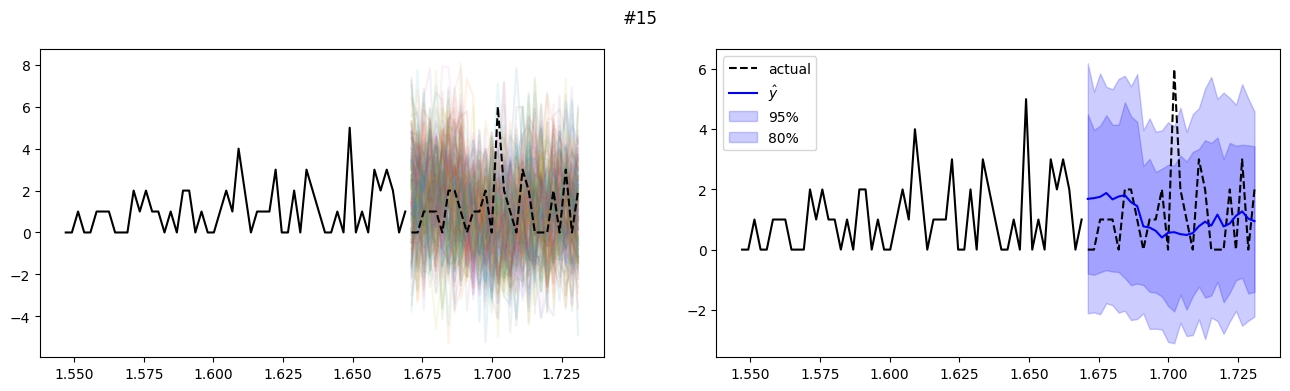

In [22]:
# Plots

S = 15

scaler = torch.distributions.AffineTransform(loc=0, scale=vtest[S])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'#{S}')

# samples plot
ax1.plot(Xtest[S,:ENCODER_LEN,1], scaler(Xtest[S,:ENCODER_LEN,0]), color='black')
for p in range(paths.shape[1]):
    ax1.plot(Xtest[S,-DECODER_LEN:,1], paths[S,p], alpha=0.1)
ax1.plot(Xtest[S,-DECODER_LEN:,1], Ytest[S,-DECODER_LEN:], color='black', linestyle='--')

# prediction intervals plot
serie_mean = np.median(paths[S], axis=0)
serie_hi95 = np.quantile(paths[S], 0.975, axis=0)
serie_hi80 = np.quantile(paths[S], 0.9, axis=0)
serie_lo95 = np.quantile(paths[S], 0.025, axis=0)
serie_lo80 = np.quantile(paths[S], 0.1, axis=0)
ax2.plot(Xtest[S,:ENCODER_LEN,1], scaler(Xtest[S,:ENCODER_LEN,0]), color='black')
ax2.plot(Xtest[S,-DECODER_LEN:,1], Ytest[S,-DECODER_LEN:], color='black', linestyle='--', label='actual')
ax2.plot(Xtest[S,-DECODER_LEN:,1], serie_mean, color='blue', label='$\hat{y}$')
ax2.fill_between(Xtest[S,-DECODER_LEN:,1], serie_lo95, serie_hi95, color='blue', alpha=0.2, label='95%')
ax2.fill_between(Xtest[S,-DECODER_LEN:,1], serie_lo80, serie_hi80, color='blue', alpha=0.2, label='80%')
ax2.legend(loc='upper left')
plt.show()

In [19]:
# Metrics
from properscoring import crps_ensemble

def SMAPE(y, yhat):
    return 2 * ( np.abs(y - yhat) / (np.abs(y) + np.abs(yhat) + 1e-8) )

def CRPS(y, yhat):
    res = np.empty((y.shape[0], y.shape[1]))
    for i in range(y.shape[0]):
        for t in range(y.shape[1]):
            res[i,t] = crps_ensemble(y[i,t], yhat[i,:,t])
    return res

In [20]:
actual = Ytest[:,-DECODER_LEN:]
yhat = np.median(paths, axis=1)
yhat_samples = paths.copy()
yhat_hi95 = np.quantile(paths, 0.975, axis=1)
yhat_lo95 = np.quantile(paths, 0.25, axis=1)

print(f'sMAPE: {np.mean(np.mean(SMAPE(actual, yhat), axis=1)):.3f}')
print(f'CRPS:  {np.mean(np.mean(CRPS(actual, yhat_samples), axis=1)):.3f}')

sMAPE: 1.367
CRPS:  1.138
